### ステップ9
## 拡散モデルの実装

話の流れ\
拡散モデルで使用するニューラルネットワークの紹介\
↓\
正弦波位置エンコーディング\
↓\
拡散モデルの実装\
↓\
MNISTデータセット

## 1.U-Net
拡散モデルで使用するニューラルネットワークの数式は$\varepsilon_{\theta}(x_{t},t)$で表され、下9-1のようにノイズを予測する。
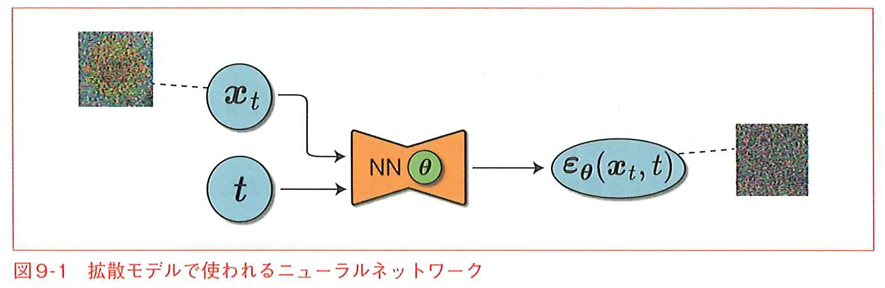\
\
$\varepsilon_{\theta}(x_{t},t)$への入力が２つあるため、先に入力が$x_{t}$のみの9-2図のモデルを実装し、その後9-1図のモデルを実装する。
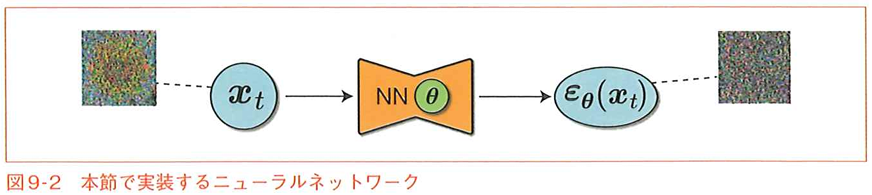\
\
9-2図のような出力と入力の形状が同じニューラルネットワークを持つモデルはU-Net以外にもAutoEncoderやECNが挙げられる。

### U-Netとは？
医療画像のセマンティック・セグメンテーションのために開発されたモデル。\
セマンティック・セグメンテーション：\
画像の対象物を特定のカテゴリごとに分類↓\
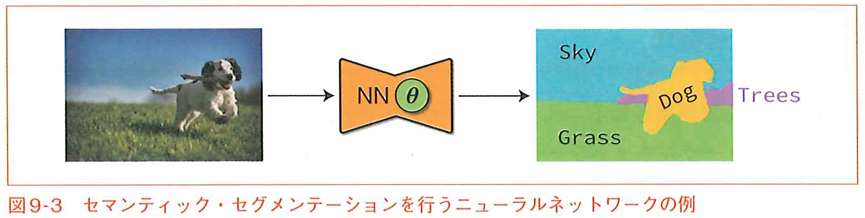\
\
入力する画像データの形状は（チャンネル数,画像の高さ,画像の幅）。\
出力は（カテゴリに属する確率,画像の高さ,画像の幅）の形状のテンソル。\
拡散モデルではチャンネル数＝カテゴリに属する確率分布とする。\
\
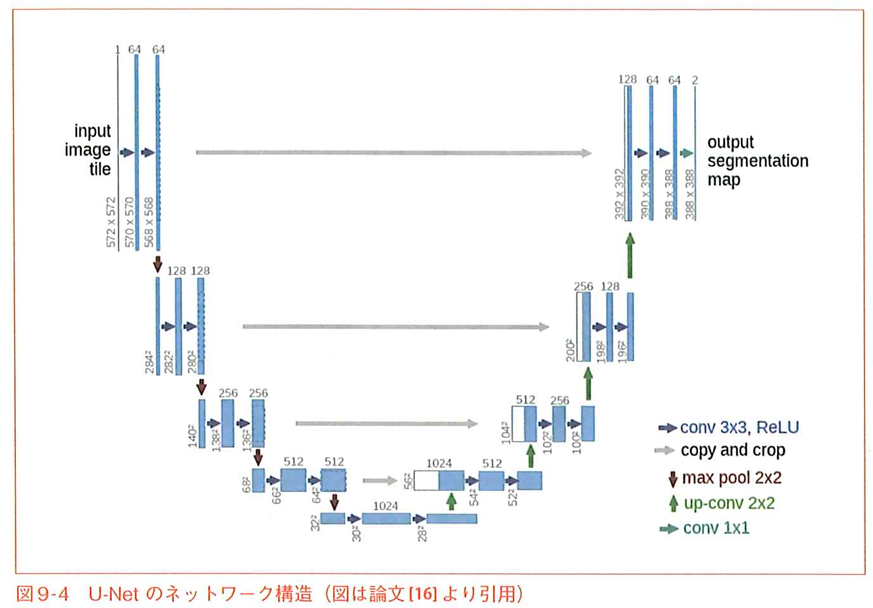\
U-Netではダウンサンプリングで重要な特徴を抽出した（左側）後、アップサンプリングで詳細な情報を復元していく（右側）。スキップ接続（グレー矢印）で直接情報を伝えることでアップサンプリングの復元を正確にすることができる。

### U-Netの実装
MNISTデータを想定して図9-4よりもシンプルに実装していく↓\
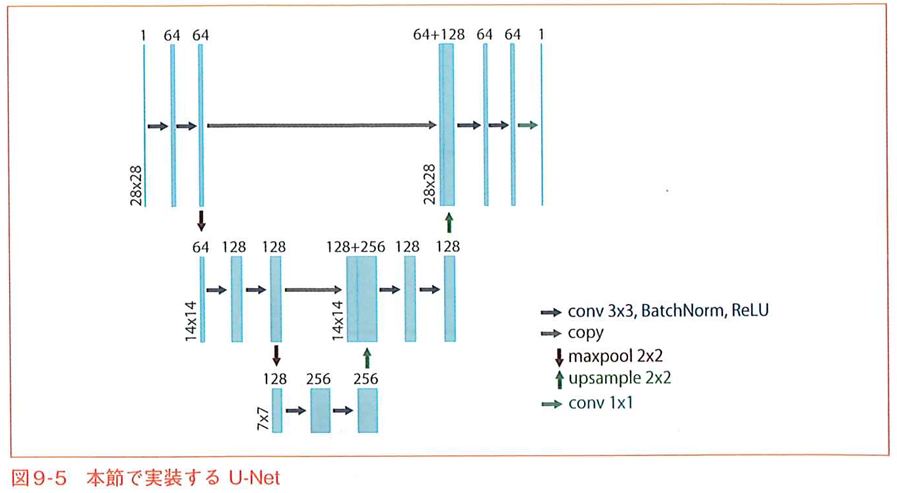\
アップサンプリングとダウンサンプリングをそれぞれ2回行ない、各ステージでは2回畳み込みする。まずは、畳み込みのConvBlockクラスを実装する。\
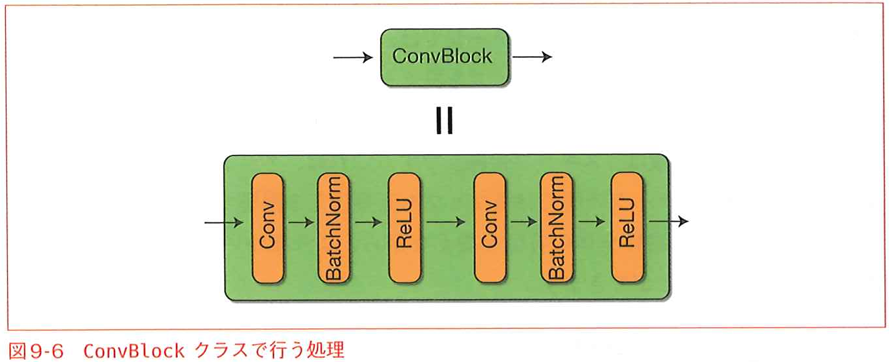

In [3]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            #1つ目の畳み込み層,バッチ正規化,ReLU関数
            nn.Conv2d(in_ch, out_ch, 3, padding=1), #pandding=1で画像サイズを保持
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            #2つ目の畳み込み層,バッチ正規化,ReLU関数
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.convs(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=1): #グレーだから1
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64) #入力チャネル数1 → 64
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256) #ボトルネック
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        #ダウンサンプリング
        self.maxpool = nn.MaxPool2d(2)
        #アップサンプリング
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x1 = self.down1(x)            #(64, 28, 28)
        x = self.maxpool(x1)          #(64, 14, 14)
        x2 = self.down2(x)            #(128, 14, 14)
        x = self.maxpool(x2)          #(128, 7, 7)
        x = self.bot1(x)              #(256, 7, 7)

        x = self.upsample(x)          #(256, 14, 14)
        x = torch.cat([x, x2], dim=1) #(128+256, 14, 14) スキップ接続
        x = self.up2(x)               #(128, 14, 14)
        x = self.upsample(x)          #(128, 28, 28)
        x = torch.cat([x, x1], dim=1) #(64+128, 28, 28) スキップ接続
        x = self.up1(x)               #(64, 28, 28)
        x = self.out(x)               #(1, 28, 28)
        return x

In [5]:
model = UNet()
x = torch.randn(10, 1, 28, 28) #ダミー
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


$x_{t}$のU-Netを実装したため、次は時刻$t$をU-Netに組み込む。このとき、整数である$t$をベクトルに変換して進行度合いを把握するために正弦波位置エンコーディングを使用する。Transformerモデルで有名になった。

### 正弦波位置エンコーディング

整数$t$をベクトル$v$に変換するとき、$v$の次元を$D$とすると、$i$番目の要素は次の式で表される。

\begin{equation*}
    v_{i} = 
        \begin{cases}
            \sin (\frac{t}{10000^{\frac{i}{D}}}) & (iが偶数のとき) \\
            \cos (\frac{t}{10000^{\frac{i}{D}}}) & (iが奇数のとき)
        \end{cases}
\end{equation*}

$\sin$や$\cos$であれば、値が-1から1の間に収まるため値が大きくなりすぎて意味情報が打ち消されることがない。（自然言語処理）\
また、周期性から同じ値を返さないように、1周期を大きくする必要がある。iの値が小さいときに、sinだけだと値がほとんど変化しないため、cosと交互にすることで値に変化を持たせる。

In [ ]:
#正弦波位置エンコーディング
def _pos_encording(t, output_dim, device='cpu'):
    D = output_dim
    v = torch.zeros(D, device=device) #vの初期化

    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i /D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

In [7]:
v = _pos_encording(1, 16)
print(v.shape)

torch.Size([16])


In [ ]:
#正弦波位置エンコーディングver.バッチ処理
def pos_encording(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encording(ts[i], output_dim, device=device)
    return v

In [9]:
v =pos_encording(torch.tensor([1, 2, 3]), 16)
print(v.shape)

torch.Size([3, 16])


### tを含めたU-Netの構築
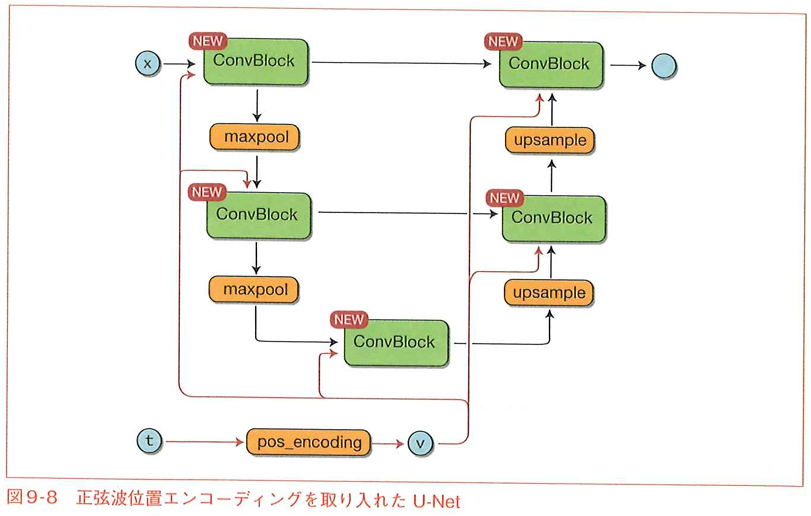
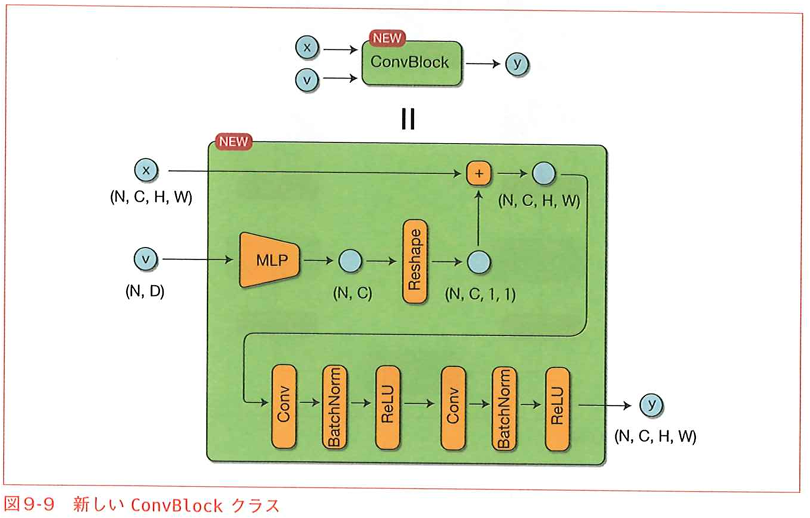

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch,time_embed_dim):
        super().__init__()
        #畳み込み層の定義
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        #時刻埋め込みのMLP
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch), #(N, time_embed_dim) → (N, in_ch)
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x,v):
        N, C, _, _ = x.shape
        v =self.mlp(v) #時刻埋め込み
        v = v.view(N, C, 1, 1) #(N, in_ch) → (N, in_ch, 1, 1)
        y = self.convs(x + v) #時刻埋め込みを足して畳み込み
        return y
    
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_enbed_dim=100):
        super().__init__()
        self.time_enbed_dim = time_enbed_dim

        self.down1 = ConvBlock(in_ch, 64, time_enbed_dim)
        self.down2 = ConvBlock(64, 128, time_enbed_dim)
        self.bot1 = ConvBlock(128, 256, time_enbed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_enbed_dim)
        self.up1 = ConvBlock(64 + 128, 64, time_enbed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        #正弦波位置エンコーディング
        v = pos_encording(timesteps, self.time_enbed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x
    

### 拡散過程
ガウスノイズを追加する拡散過程の実装の前に、まずは$q(x_{t}|x_{t-1})$の実装をする。

### $q(x_{t}|x_{t-1})$からのサンプリング

拡散モデルの$q(x_{t}|x_{t-1})$は次の式で表される。
\begin{equation*}
q(x_{t}|x_{t-1})=\mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1}, \beta_{t}I)
\end{equation*}
\
変数変換するとサンプリングは次の式で表せる。
\begin{equation*}
\epsilon \sim \mathcal{N}(0,I)
\end{equation*}

\begin{equation*}
x_{t}=\sqrt{1-\beta_{t}}x_{t-1}+\sqrt{\beta_{t}}\epsilon
\end{equation*}

In [ ]:
x = torch.randn(3, 64, 64) #ダミー
T = 1000
betas = torch.linspace(0.0001, 0.02, T) #0.0001から0.02までのT個

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x) #xと同じ形状のガウスノイズ生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

In [ ]:
import os
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

#画像読み込み
current_dir = os.getcwd() #修正
file_path = os.path.join(current_dir, 'flower.png')
image = plt.imread(file_path)
print(image.shape)

#画像の前処理定義
preprocess = transforms.ToTensor() 
x = preprocess(image)
print(x.shape)

(64, 64, 3)
torch.Size([3, 64, 64])


In [ ]:
def reverse_to_img(x):
    x = x* 255
    x= x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage() #テンソルを画像に変換
    return to_pil(x)

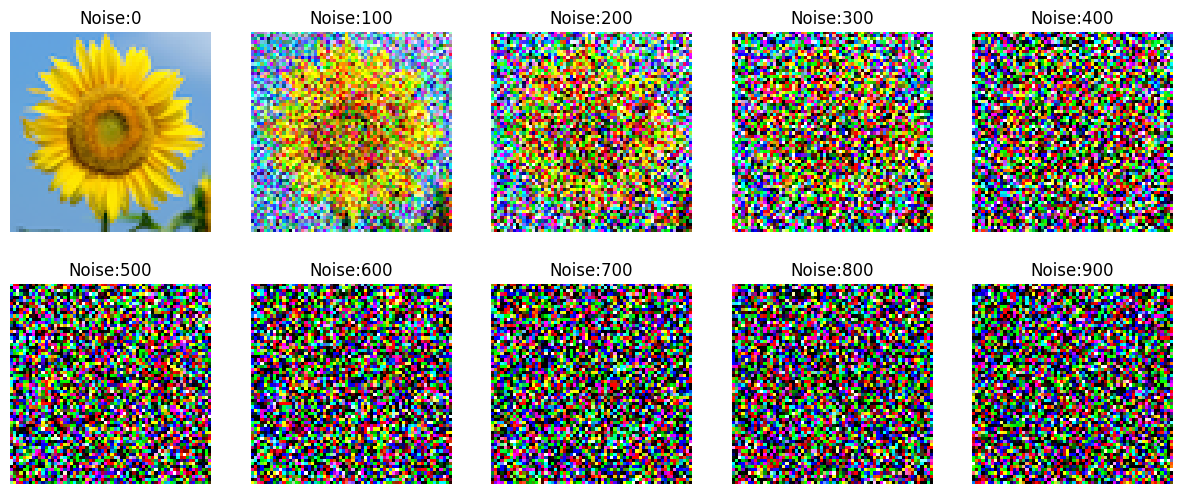

In [17]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)
    
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

#画像を表示
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Noise:{i * 100}')
    plt.axis('off')

plt.show()

### $q(x_t|x_0)$からのサンプリング

$q(x_{t}|x_{0})$は次のように表すことができる。\
●ハイパーパラメータの関係式
\begin{align*}
    &\alpha_{t}=1-\beta_{t}\\
    &\bar{\alpha_{t}}=\alpha_{t}\alpha_{t-1}\ldots\alpha_1
\end{align*}

●確率分布：$q(x_{t}|x_{0})$
\begin{equation*}
    q(x_{t}|x_{0})=\mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})I)
\end{equation*}

●$q(x_{t}|x_{0})$からのサンプリング
\begin{align*}
    &\epsilon \sim \mathcal{N}(0,I)\\
    &x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon
\end{align*}

$\bar{\alpha_t}=\alpha_t\alpha_{t-1}\ldots\alpha_1$の計算をするためにtorch.cumprod()関数を使う。\
torch.cumprod()は、テンソルの累積積を計算する。累積積とは指定した次元に沿って、それまでの要素のすべての積を計算する。


In [ ]:
x = torch.tensor([1, 2, 3, 4])
output = torch.cumprod(x, dim=0) #xが入力,dimが次元
print(output)

tensor([ 1,  2,  6, 24])


この出力は、[1, 1\*2, 1\*2\*3, 1\*2\*3\*4]を計算した結果になっている。\
次に、$q(x_t|x_0)$からのサンプリング処理を実装していく。

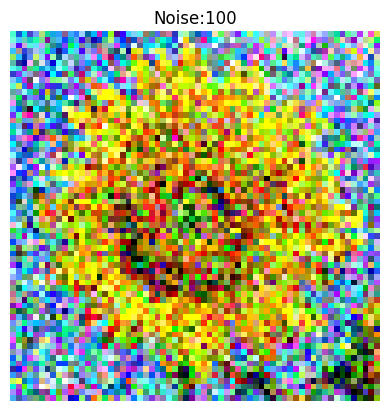

In [ ]:
#画像読み込み
current_dir = os.getcwd() #修正
file_path = os.path.join(current_dir, 'flower.png')
img = plt.imread(file_path)
x = preprocess(img) #画像をテンソルに変換し、正規化

T = 1000
beta_start = 0.0001
beta_end = 0.02
#0.0001から0.02までのT個のノイズのパラメータ
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    aloha_bars = torch.cumprod(alphas, dim=0) #累積積
    t_idx = t - 1
    alpha_bar = aloha_bars[t_idx]

    eps = torch.randn_like(x_0) #ノイズ生成
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    return x_t

#時刻t=100での画像生成
t = 100
x_t = add_noise(x, t, betas)

#画像表示
img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise:{t}')
plt.axis('off')
plt.show()

### Diffuserクラスの実装
ここまでのコードをDuffuserクラスとして１つにまとめる。

denoiseメソッドでは学習済みモデルを使用してノイズ付き画像を元の画像に近づける処理をする。denoiseメソッドに以下の擬似コードの中のFor文を実装する。\
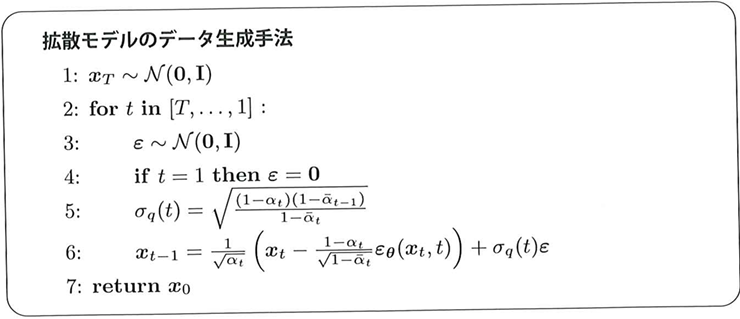

In [ ]:
from tqdm import tqdm

class Diffuser:
    def __init__(self,num_timesteps=1000, beta_start=0.0001,
                 beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)

        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.shape[0] #バッチサイズ
        alpha_bar = alpha_bar.view(N, 1, 1, 1) #画像xの形状(N, C, H, W)に合わせる

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise
    
    def denoise(self, model, x,t):
        #ｔの各要素が1以上かつＴ以下であることを確認
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        #ブロードキャストが正しく行われるための設定
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad(): #勾配計算を停止
            #入力画像xと時刻tから推定ノイズepsを生成
            eps = model(x, t)
            model.train()

            noise = torch.randn_like(x, device=self.device)
            #復元のためにあえてノイズ付き画像をそのまま残す
            noise[t == 1] = 0

            #モデルによって推定されたノイズを用いて画像を復元
            mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) /torch.sqrt(alpha)
            std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) /(1 - alpha_bar))
            return mu + noise * std
        
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x =x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28,28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images

### MNISTデータを用いた拡散モデルの学習

拡散モデルの学習を今までのコードに追加する。\
擬似コードは以下のようになる。\
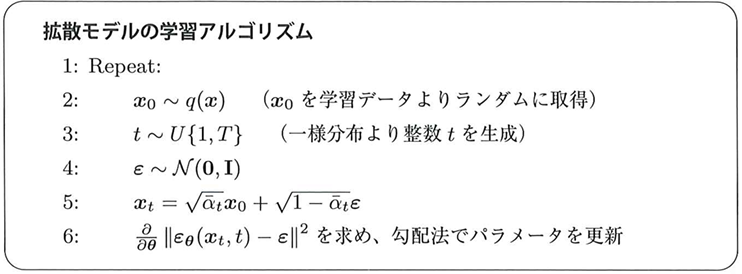

100%|██████████| 469/469 [11:30<00:00,  1.47s/it]


Epoch:0 | Loss:0.04676354935031329


100%|██████████| 469/469 [27:54<00:00,  3.57s/it] 


Epoch:1 | Loss:0.02671390011318838


100%|██████████| 469/469 [12:16<00:00,  1.57s/it]


Epoch:2 | Loss:0.024178714255121216


100%|██████████| 469/469 [12:18<00:00,  1.57s/it]


Epoch:3 | Loss:0.021756061718169687


100%|██████████| 469/469 [12:17<00:00,  1.57s/it]


Epoch:4 | Loss:0.020567141667898022


100%|██████████| 469/469 [12:10<00:00,  1.56s/it]


Epoch:5 | Loss:0.019881339497498866


100%|██████████| 469/469 [12:10<00:00,  1.56s/it]


Epoch:6 | Loss:0.01916138913387111


100%|██████████| 469/469 [12:10<00:00,  1.56s/it]


Epoch:7 | Loss:0.018772057231777765


100%|██████████| 469/469 [12:11<00:00,  1.56s/it]


Epoch:8 | Loss:0.018460414924426502


100%|██████████| 469/469 [11:54<00:00,  1.52s/it]

Epoch:9 | Loss:0.01846396693709626


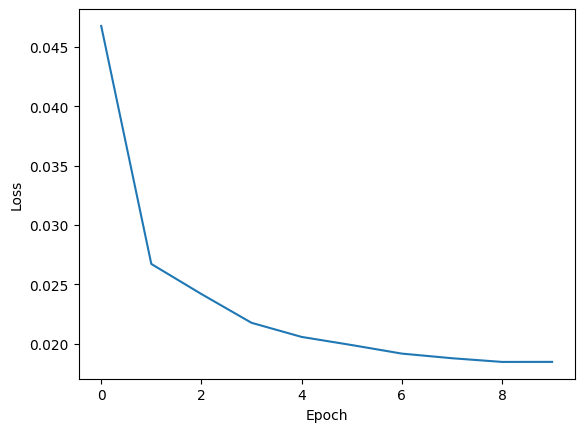

100%|██████████| 1000/1000 [01:16<00:00, 13.07it/s]


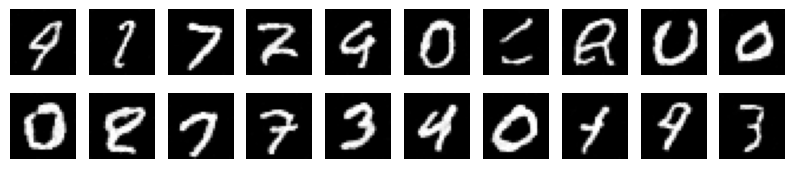

In [ ]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#画像をグリッド形式で表示
def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off') #軸を非表示
            i += 1

    plt.show()

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    #エポックごとにデータ生成して結果を確認したい場合は下記のコメントアウトを取る
    #images = diffuser.sample(model)
    #show_images(images)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t) #
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch:{epoch} | Loss:{loss_avg}')

#損失のグラフ
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#画像生成
images = diffuser.sample(model)
show_images(images)